In [4]:
import os
# os.getcwd(), os.listdir('/content/')

In [7]:
import pandas as pd
sents = pd.read_csv('amaz_df.csv', sep = ';')
sents.shape

(60000, 2)

In [8]:
train_sentences, test_sentences = sents['sentences'].iloc[:50000], sents['sentences'].iloc[50000:]

train_labels, test_labels = sents['labels'].iloc[:50000], sents['labels'].iloc[50000:]

In [1]:
!pip install tensorflow-gpu==1.15
# !pip install tensorflow==1.15
!pip uninstall keras -y
!pip install keras==2.2.3

print("Correct version of tensorflow and Keras installed")


import tensorflow as tf 
print(f" Tensorflow version ---> {tf.__version__}")
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

  
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# sess

     |████████████████████████████████| 411.5MB 38kB/s 
     |████████████████████████████████| 3.8MB 55.6MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 512kB 54.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8d29d1b3e6bda78e14e65edabe065ef262d2ab1ce48ad69c442ac658fd8076c8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing instal

In [2]:
import tensorflow as tf
import tensorflow_hub as hub


elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
init = tf.initialize_all_variables()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [9]:
def fast_pre_process(msgs:list):
    import time
    import re
    t0 = time.time()
    msgs = list(map(lambda text:re.sub('[^a-zA-Z0-9]+', ' ',text), msgs))
    msgs = list(map(lambda x: (x.lower()), msgs))
    print(f"Time taken to process: {str(time.time() - t0)[:2]} secs")
    return msgs


processed_train_elmo, processed_test_elmo = fast_pre_process(train_sentences), fast_pre_process(test_sentences)
len(processed_train_elmo), len(processed_test_elmo)

Time taken to process: 1. secs
Time taken to process: 0. secs


(50000, 10000)

In [10]:
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module("https://tfhub.dev/google/elmo/3",
                               trainable=self.trainable,name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [11]:
# Function to build model
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense0 = layers.Dense(256, activation='relu')(embedding)
    dense1 = layers.Dense(64, activation='relu')(dense0)
    pred = layers.Dense(2, activation='sigmoid')(dense1)

    model = Model(inputs=[input_text], outputs=pred)
    

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    print(model.summary())

    return model#, model_embeddings

Skip next 3 cells if model is already pretrained.

In [12]:
# Build and fit
import numpy as np


from keras.utils import to_categorical
model = build_model()


history = model.fit(np.array(processed_train_elmo), 
          to_categorical(train_labels.values),
          validation_split = 0.2,
          epochs=10,
          batch_size = 112)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 278,982
Trainable params: 278,982
Non-trainable params: 0
_________________________________________________________________
None



Train on 40000 samples, validate on 10000 samples
Epoch 1/10



40000/40000 [==============================] - 1037s 26ms/step - loss: 0.3332 - categorical_accuracy: 0.8558 - val_loss: 0.3055 - val_categorical_accuracy: 0.8684
Epoch 2/10
40000/40000 [==============================] - 967s 24ms/step - loss: 0.2846 - categorical_accuracy: 0.8820 - val_loss: 0.3062 - val_categorical_accuracy: 0.8668
Epoch 3/10
40000/40000 [==============================] - 959s 24ms/step - loss: 0.2642 - categorical_accuracy: 0.8916 - val_loss: 0.2741 - val_categorical_accuracy: 0.8867
Epoch 4/10
40000/40000 [==============================] - 960s 24ms/step - loss: 0.2541 - categorical_accuracy: 0.8950 - val_loss: 0.2884 - val_categorical_accuracy: 0.8876
Epoch 5/10
40000/40000 [==============================] - 963s 24ms/step - loss: 0.2471 - categorical_accuracy: 0.9000 - val_loss: 0.2827 - val_categorical_accuracy: 0.8884
Epoch 6/10
40000/40000 [==============================] - 958s 24ms/step - loss: 0.2326 - categorical_accuracy: 0.9053 - val_loss: 0.3137 - val_c

In [13]:
model.save("model_12e_.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)


Saved model to disk


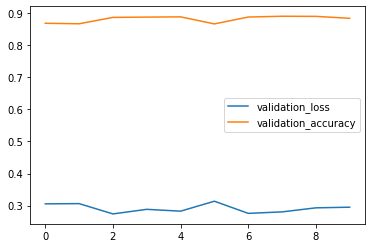

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['validation_loss', 'validation_accuracy'])

# Load weights to a new model

In [ ]:
# # # Clear and load model
# import numpy as np
# from keras.utils import to_categorical

# model = None
# model = build_model()
# model.load_weights('model_10e_.h5')

# model.evaluate(np.array(processed_test_elmo), 
#           to_categorical(test_labels.values))

In [15]:
for layer in model.layers:
    print(layer.name)
    if 'elmo' in layer.name:
        print(" We got elmo's layer name!! ")
        elmo_layer = layer.name
    print(" ")

input_1
 
elmo_embedding_layer_1
 We got elmo's layer name!! 
 
dense_1
 
dense_2
 
dense_3
 


In [16]:
elmo_out = model.get_layer(elmo_layer).output

In [17]:
model_embeddings = Model(inputs=model.input, outputs=elmo_out)

Using First layer for Create Embeddings. We could this in one step by using model.predict method on the whole text but we want to know exactly  which sample we are computing, although this approach might take way longer. Again, next 4 cells can be skipped if embeddings have been already extracted

In [21]:
import time
from datetime import timedelta
from tqdm import notebook

start = time.time()


embs_train = list()

for i in notebook.tqdm(np.array(processed_train_elmo)[:10000]):
    embs_train.append(model_embeddings.predict(i.reshape((1))))

embs_train = np.array(embs_train).reshape((len(processed_train_elmo[:10000]), 1024))

elapsed = (time.time() - start)

np.savetxt("embs_10k_train.csv", embs_train, delimiter=",")
print(f" Time taken to extract elmo embs ---> {str(timedelta(seconds=elapsed))[:-7]}")


 Time taken to extract elmo embs ---> 0:31:18


In [22]:
import time
from datetime import timedelta
from tqdm import notebook

start = time.time()


embs_test= list()

for i in notebook.tqdm(np.array(processed_test_elmo)[:2000]):
    embs_test.append(model_embeddings.predict(i.reshape((1))))

embs_test = np.array(embs_test).reshape((len(processed_test_elmo[:2000]), 1024))
np.savetxt("embs_2k_test.csv", embs_test, delimiter=",")
elapsed = (time.time() - start)
print(f" Time taken to extract elmo test set embs ---> {str(timedelta(seconds=elapsed))[:-7]}")


 Time taken to extract elmo test set embs ---> 0:06:08


We are trying to improve that 89% accuracy by using other classical classifiers